In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from scipy import stats
import seaborn as sns

sns.set(rc={'figure.figsize':(15,10)})
resultado_anterior = 0

In [2]:
def modelfit(model, features, labels, usarCrossValidation=True, cv_folds=5, early_stopping_rounds=50):
    if usarCrossValidation:
        parametros = model.get_xgb_params()
        dmatrix = xgb.DMatrix(features.values, label=labels.values)
        cvresult = xgb.cv(parametros, dmatrix, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='auc', early_stopping_rounds=early_stopping_rounds)
        model.set_params(n_estimators=cvresult.shape[0])
    
    model.fit(features, labels,eval_metric='auc')
    
def obtener_marca(serie_de_modelo,prefix=""):
    # La marca es siempre la primer palabra del modelo
    r = []
    for modelo in serie_de_modelo.tolist():
        if pd.isna(modelo):
            r.append("Unknown")
        else:
            r.append(prefix + modelo.split()[0])
    return r

### Lectura csv

In [3]:
df = pd.read_csv('events_up_to_01062018.csv', low_memory = False, parse_dates = ['timestamp'], infer_datetime_format = True,
                    dtype = {'event': 'category','condition': 'category','storage': 'category', 'color': 'category', 'staticpage': 'category', 'campaign_source': 'category', 'search_engine': 'category', 'channel': 'category', 'new_vs_returning': 'category', 'region': 'category', 'country': 'category', 'device_type': 'category'})
labels = pd.read_csv('labels_training_set.csv', low_memory = False).set_index('person')

### Creacion de features

In [4]:
#
###                               CREACION DF PREDICTOR
#

dfPredictor = pd.DataFrame(df['person'].unique())
dfPredictor.columns = ['person']
dfPredictor = dfPredictor.set_index('person')

#
###                               FILTRADO DE FECHAS
#

ult60Dias = df.loc[df['timestamp'] > pd.to_datetime('01-04-2018')]
ult30Dias = df.loc[(df['timestamp'] > pd.to_datetime('01-05-2018'))]# & (df['timestamp'] > pd.to_datetime('15-05-2018'))]
ult15Dias = df.loc[(df['timestamp'] > pd.to_datetime('15-05-2018'))]# & (df['timestamp'] > pd.to_datetime('25-05-2018'))]
ult5Dias = df.loc[(df['timestamp'] > pd.to_datetime('25-05-2018'))]# & (df['timestamp'] > pd.to_datetime('31-05-2018'))]
ultDia = df.loc[df['timestamp'] > pd.to_datetime('31-05-2018')]

#
###                               CREACION DE FEATURES
#

#
##  POR EVENTO


#  CHECKOUTS

checkoutsPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt60Dias.columns = ['checkoutsUlt60Dias']

checkoutsPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt30Dias.columns = ['checkoutsUlt30Dias']

checkoutsPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt15Dias.columns = ['checkoutsUlt15Dias']

checkoutsPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUlt5Dias.columns = ['checkoutsUlt5Dias']

checkoutsPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'checkout']['person'].value_counts().to_frame()
checkoutsPorPersonaUltDia.columns = ['checkoutsUltDia']


dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(checkoutsPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  CONVERSIONES

conversionesPorPersonaUlt60Dias = ult60Dias.loc[ult60Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt60Dias.columns = ['conversionesUlt60Dias']

conversionesPorPersonaUlt30Dias = ult30Dias.loc[ult30Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt30Dias.columns = ['conversionesUlt30Dias']

conversionesPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt15Dias.columns = ['conversionesUlt15Dias']

conversionesPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUlt5Dias.columns = ['conversionesUlt5Dias']

conversionesPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'conversion']['person'].value_counts().to_frame()
conversionesPorPersonaUltDia.columns = ['conversionesUltDia']

dfPredictor = dfPredictor.join(conversionesPorPersonaUlt60Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt30Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(conversionesPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#  VISITAS

visitasUlt15DiasPorPersona = ult15Dias.loc[ult15Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt15DiasPorPersona.columns = ['CantVisitasUlt15Dias']

visitasUlt5DiasPorPersona = ult5Dias.loc[ult5Dias['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUlt5DiasPorPersona.columns = ['CantVisitasUlt5Dias']

visitasUltDiaPorPersona = ultDia.loc[ultDia['event'] == 'visited site']['person'].value_counts().to_frame()
visitasUltDiaPorPersona.columns = ['CantVisitasUltDia']

dfPredictor = dfPredictor.join(visitasUlt15DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUlt5DiasPorPersona, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(visitasUltDiaPorPersona, how = 'left', on = 'person').fillna(value = 0)


#  VIEWED PRODUCT

viewedProductPorPersonaUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt15Dias.columns = ['viewedProductUlt15Dias']

viewedProductPorPersonaUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUlt5Dias.columns = ['viewedProductUlt5Dias']

viewedProductPorPersonaUltDia = ultDia.loc[ultDia['event'] == 'viewed product']['person'].value_counts().to_frame()
viewedProductPorPersonaUltDia.columns = ['viewedProductUltDia']

dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(viewedProductPorPersonaUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### POR CANAL DE ORIGEN

visitasUlt15Dias = ult15Dias.loc[ult15Dias['event'] == 'visited site']
visitasUlt5Dias = ult5Dias.loc[ult5Dias['event'] == 'visited site']
visitasUltDia = ultDia.loc[ultDia['event'] == 'visited site']

#  PAGO

paidUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt15Dias.columns = ['CanalPagoUlt15Dias']

paidUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUlt5Dias.columns = ['CanalPagoUlt5Dias']

paidUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Paid']['person'].value_counts().to_frame()
paidUltDia.columns = ['CanalPagoUltDia']

dfPredictor = dfPredictor.join(paidUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(paidUltDia, how = 'left', on = 'person').fillna(value = 0)


#  ORGANIC

organicUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt15Dias.columns = ['CanalOrganicoUlt15Dias']

organicUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUlt5Dias.columns = ['CanalOrganicoUlt5Dias']

organicUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Organic']['person'].value_counts().to_frame()
organicUltDia.columns = ['CanalOrganicoUltDia']

dfPredictor = dfPredictor.join(organicUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(organicUltDia, how = 'left', on = 'person').fillna(value = 0)


#  DIRECT

directUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt15Dias.columns = ['CanalDirectoUlt15Dias']

directUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Direct']['person'].value_counts().to_frame()
directUlt5Dias.columns = ['CanalDirectoUlt5Dias']

directUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Direct']['person'].value_counts().to_frame()
directUltDia.columns = ['CanalDirectoUltDia']

dfPredictor = dfPredictor.join(directUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(directUltDia, how = 'left', on = 'person').fillna(value = 0)


#  REFERRAL

referralUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt15Dias.columns = ['CanalReferidoUlt15Dias']

referralUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUlt5Dias.columns = ['CanalReferidoUlt5Dias']

referralUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Referral']['person'].value_counts().to_frame()
referralUltDia.columns = ['CanalReferidoUltDia']

dfPredictor = dfPredictor.join(referralUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(referralUltDia, how = 'left', on = 'person').fillna(value = 0)


#  SOCIAL

socialUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt15Dias.columns = ['CanalSocialUlt15Dias']

socialUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Social']['person'].value_counts().to_frame()
socialUlt5Dias.columns = ['CanalSocialUlt5Dias']

socialUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Social']['person'].value_counts().to_frame()
socialUltDia.columns = ['CanalSocialUltDia']

dfPredictor = dfPredictor.join(socialUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(socialUltDia, how = 'left', on = 'person').fillna(value = 0)


#  EMAIL

emailUlt15Dias = visitasUlt15Dias.loc[visitasUlt15Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt15Dias.columns = ['CanalEmailUlt15Dias']

emailUlt5Dias = visitasUlt5Dias.loc[visitasUlt5Dias['channel'] == 'Email']['person'].value_counts().to_frame()
emailUlt5Dias.columns = ['CanalEmailUlt5Dias']

emailUltDia = visitasUltDia.loc[visitasUltDia['channel'] == 'Email']['person'].value_counts().to_frame()
emailUltDia.columns = ['CanalEmailUltDia']

dfPredictor = dfPredictor.join(emailUlt15Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUlt5Dias, how = 'left', on = 'person').fillna(value = 0)
dfPredictor = dfPredictor.join(emailUltDia, how = 'left', on = 'person').fillna(value = 0)


#
### FEATURES AVANZADOS

#  CANTIDAD DE CHECKOUTS POR MARCA

#marcas = {'Samsung':'Samsung', 'Motorola':'Motorola', 'iPhone':'iPhone', 'LG':'LG', 'Sony':'Sony', 'Lenovo':'Lenovo','iPad':'iPad', 'Quantum':'Quantum', 'Asus':'Asus'}
prefijo = "total_checks_"
#marcas = {marca: prefijo + nombreFeature for marca, nombreFeature in marcas.items()}

total_checks = df.loc[df["event"]=="checkout"].copy()
total_checks["Marca"] = obtener_marca(total_checks["model"],prefijo)
#total_checks = total_checks.loc[(total_checks["Marca"]==marcas["iPhone"])|(total_checks["Marca"]==marcas["Samsung"])]
total_checks["contador"] = 1
total_checks=total_checks.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_checks, how = 'left', on = 'person').fillna(value = 0)

prefijo = "total_views_"
total_views = ult30Dias.loc[ult30Dias["event"]=="viewed product"].copy()
total_views["Marca"] = obtener_marca(total_views["model"],prefijo)
#total_views = total_views.loc[(total_views["Marca"]==marcas["iPhone"])|(total_views["Marca"]==marcas["Samsung"])]
total_views["contador"] = 1
total_views=total_views.loc[:,["Marca","person","contador"]].groupby(["person","Marca"]).agg({"contador":"sum"}).reset_index()\
    .pivot(columns='Marca', index='person', values='contador').fillna(0)
dfPredictor = dfPredictor.join(total_views, how = 'left', on = 'person').fillna(value = 0)


### Cuantas veces hizo checkout de los 20 celus mas visitados
view_products = df.loc[df["event"] == "viewed product",["model"]].copy()
view_products["Visitas"] = 1
phones20view = view_products.groupby(by=["model"]).agg("sum").sort_values(by="Visitas",ascending=False).head(20).index.tolist()
checkouts = df.loc[df["event"]=="checkout",["person","model"]].copy()
def estaDentroDe(serie,lista):
    r = []
    for i in serie:
        if i in lista:
            r.append(True)
        else:
            r.append(False)
    return r
checkouts["model"] = estaDentroDe(checkouts["model"],phones20view)
checkouts= checkouts.groupby("person").agg("sum")
dfPredictor = dfPredictor.join(checkouts, how = 'left', on = 'person').fillna(value = 0)


### Agregado y quitado de features y cambio de disposicion de las columnas

In [5]:
dfPredictor.columns

Index(['checkoutsUlt60Dias', 'checkoutsUlt30Dias', 'checkoutsUlt15Dias',
       'checkoutsUlt5Dias', 'checkoutsUltDia', 'conversionesUlt60Dias',
       'conversionesUlt30Dias', 'conversionesUlt15Dias',
       'conversionesUlt5Dias', 'conversionesUltDia', 'CantVisitasUlt15Dias',
       'CantVisitasUlt5Dias', 'CantVisitasUltDia', 'viewedProductUlt15Dias',
       'viewedProductUlt5Dias', 'viewedProductUltDia', 'CanalPagoUlt15Dias',
       'CanalPagoUlt5Dias', 'CanalPagoUltDia', 'CanalOrganicoUlt15Dias',
       'CanalOrganicoUlt5Dias', 'CanalOrganicoUltDia', 'CanalDirectoUlt15Dias',
       'CanalDirectoUlt5Dias', 'CanalDirectoUltDia', 'CanalReferidoUlt15Dias',
       'CanalReferidoUlt5Dias', 'CanalReferidoUltDia', 'CanalSocialUlt15Dias',
       'CanalSocialUlt5Dias', 'CanalSocialUltDia', 'CanalEmailUlt15Dias',
       'CanalEmailUlt5Dias', 'CanalEmailUltDia', 'total_checks_Asus',
       'total_checks_LG', 'total_checks_Lenovo', 'total_checks_Motorola',
       'total_checks_Quantum', 'total_

In [6]:
# Cambio disposicion de columnas ya que esta presenta mejor resultado
# Cuando se agregue una feature nueva, agregar el nombre de columna a esta lista para que surta efecto
# Reordenar en la lista cambia el orden de las columnas en el predictor

cols = [
'CanalDirectoUlt15Dias',
'checkoutsUlt15Dias',
'checkoutsUlt30Dias',
'checkoutsUlt5Dias',
'checkoutsUltDia',
'conversionesUlt30Dias',
'conversionesUlt15Dias',
'conversionesUlt5Dias',
'conversionesUltDia',
'CantVisitasUlt15Dias',
'CantVisitasUlt5Dias',
'CantVisitasUltDia',
'viewedProductUlt15Dias',
'viewedProductUlt5Dias',
'viewedProductUltDia',
'CanalPagoUlt5Dias',
'CanalOrganicoUlt5Dias',
'CanalDirectoUlt5Dias',
'CanalDirectoUltDia',
'CanalReferidoUlt15Dias',
'CanalReferidoUlt5Dias',
'CanalReferidoUltDia',
'total_checks_Samsung',
'total_checks_iPhone',
#'total_views_Samsung',
#'total_views_iPhone',
#'total_views_Motorola',
#'total_views_Asus',
#'total_views_LG',
#'total_views_Lenovo',

#'total_views_Quantum',
#'total_views_Sony',
#'total_views_iPad',

#'total_checks_Asus',
#'total_checks_LG',
#'total_checks_Lenovo',
#'total_checks_Motorola',
#'total_checks_Quantum',
#'total_checks_Sony',
#'checkoutsUlt60Dias',
#'conversionesUlt60Dias',
#   'CanalPagoUlt15Dias',
#   'CanalPagoUltDia',
#   'CanalOrganicoUlt15Dias',
#   'CanalOrganicoUltDia',
#    'CanalSocialUlt15Dias',
#   'CanalSocialUlt5Dias',
#   'CanalSocialUltDia',
#   'CanalEmailUlt15Dias',
#   'CanalEmailUlt5Dias',
#   'CanalEmailUltDia',
]


# Separo los labels locales
dfPredictorIndexado=dfPredictor.reindex(columns=cols)
dfPredictorLocal = dfPredictorIndexado.join(labels, how = 'inner')

### Entrenamiento del modelo

In [7]:
X, y = dfPredictorLocal.iloc[:,:-1], dfPredictorLocal.iloc[:,-1:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

modelo = xgb.XGBRegressor(
 booster='dart',
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.1,
 subsample=0.3,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=-1,
 #sample_type='weighted',
 #rate_drop=0.05,
 #skip_dropout=0.3,
 random_state=27)

modelfit(modelo, X_train, y_train)

predsa = modelo.predict(X_test)
resultado = roc_auc_score(y_test, predsa)
print(resultado)

print("Vario: {} con respecto al anterior".format(resultado-resultado_anterior))
resultado_anterior = resultado

0.8611030076723358
Vario: 0.8611030076723358 con respecto al anterior


### Creacion del submit para kaggle

In [8]:
kaggle = pd.read_csv('trocafone_kaggle_test.csv', low_memory = False)
kaggle = kaggle.set_index('person')
dfPredictorSubmit = dfPredictorIndexado.join(kaggle, how = 'inner')
predsSubmit = modelo.predict(dfPredictorSubmit)
predsSubmit[predsSubmit < 0 ] = 0
predsSubmit[predsSubmit > 1] = 1
dfPredictorSubmit['label'] = predsSubmit
dfPredictorSubmit['label'].to_frame().to_csv('submit.csv')

### Random forest para feature importance

<Figure size 1440x720 with 0 Axes>

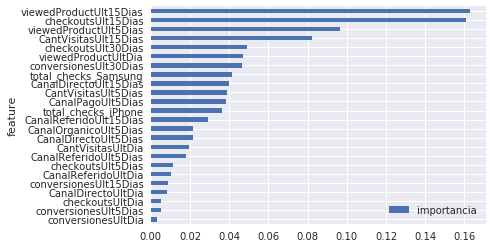

<Figure size 1440x720 with 0 Axes>

In [9]:
from sklearn.ensemble import RandomForestRegressor
names = X.columns
rf = RandomForestRegressor()
rf.fit(X_train.values, y_train.values.ravel())
impor = np.vstack((names, rf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False).iloc[::-1]
imporDf.plot(kind='barh')
plt.figure(figsize=(20,10))